# Unnormalise image

(224, 224, 3)


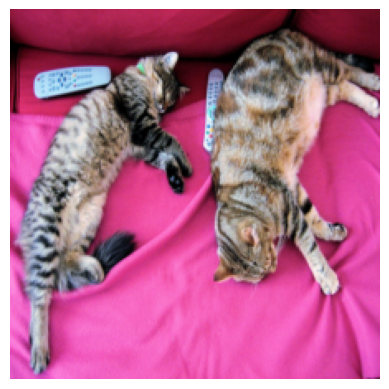

In [1]:
from transformers import ViTImageProcessor
import requests
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

image_processor = ViTImageProcessor()

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pixel_values = image_processor(image, return_tensors="pt").pixel_values
inputs = image_processor(image, return_tensors="pt")['pixel_values']

assert torch.allclose(pixel_values, inputs)
assert torch.allclose(torch.squeeze(inputs, 0), pixel_values[0])

# denormalize the pixel values for visualization purposes
mean = image_processor.image_mean
std = image_processor.image_std

# [:, None, None] = unsqueeze mean and std from (3,) -> (3,1,1). Without that expression, you will have broadcasting error
unnormalized_image = (pixel_values[0].numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
print(unnormalized_image.shape)
unnormalized_image = Image.fromarray(unnormalized_image)

plt.imshow(unnormalized_image)
plt.axis('off')
plt.show()

# Benchmark toDType -> fuse(norm, rescale) vs toDtype(scale=True) -> norm

Unlike v2.ToTensor, v2.functional.pil_to_tensor doesn't rescale uint8 image from [0,255] -> [0,1]. To solve this. there are 2 approaches: <br>
1. Convert uint8 -> float32 and rescale simultanously with v2.functional, then normalise with usual mean and std. This is what recommended by torchvision documentation
2. Convert uint8 -> float32; fuse normalisation and rescale operations to acquire scaled mean and scaled std; then normalise by scaled mean and scaled std. This is the workflow of [ViTImageProcessorFast on HuggingFace](https://github.com/huggingface/transformers/blob/main/src/transformers/image_processing_utils_fast.py#L427).

In [117]:
from torchvision.transforms import v2
from torchvision import transforms

# if functional.pil_to_tensor -> ToDtype(scale=True) isn't equivalent to ToTensor, will get assertion error
assert torch.allclose(
    v2.functional.to_dtype(v2.functional.pil_to_tensor(image), dtype=torch.float32, scale=True),
    transforms.functional.to_tensor(image)
    )

print(transforms.functional.to_tensor(image).dtype)

torch.float32


In [112]:
# torchvision v2 - setup 1
def transform_1(image):
    tensor = v2.functional.pil_to_tensor(image)
    tensor = v2.functional.to_dtype(tensor, dtype=torch.float32, scale=True)
    tensor = tensor.to('cuda')
    tensor = v2.functional.normalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    return tensor

# torchvision v2 - setup 2. Same workflow as HuggingFace's ViTImageProcessorFast
def transform_2(image):
    tensor = v2.functional.pil_to_tensor(image)
    tensor = v2.functional.to_dtype(tensor, dtype=torch.float32)
    tensor = tensor.to('cuda')
    rescale_factor = torch.tensor(255, dtype=torch.float32, device='cuda')
    tensor = v2.functional.normalize(
                tensor,
                mean=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor,
                std=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor
            )
    return tensor

# torchvision v1
def base_transform(image):
    tensor = transforms.functional.to_tensor(image)
    tensor = tensor.to('cuda')
    tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(tensor)
    return tensor

# print(transform_1(image) - transform_2(image))
# torch.norm(p=2) = L2-norm = Sum of Squared Error -> return torch.Tensor(single_element)
l2_norm_1_2 = torch.norm(transform_1(image) - transform_2(image), p=2)
l2_norm_1_base = torch.norm(transform_1(image) - base_transform(image), p=2)
l2_norm_2_base = torch.norm(transform_2(image) - base_transform(image), p=2)
print(f"L2-Norm between setup 1 and 2: {l2_norm_1_2.item()}")
print(f"L2 Norm between setup 1 and Base: {l2_norm_1_base.item()}")
print(f"L2 Norm between setup 2 and Base: {l2_norm_2_base.item()}")

# assert torch.allclose(transform_1(image), transform_2(image)) --> has checked, does get assertion error
# assert torch.allclose(transform_1(image), base_transform(image)) --> has checked, does get assertion error

L2-Norm between setup 1 and 2: 6.671059236396104e-05
L2 Norm between setup 1 and Base: 6.146348459878936e-05
L2 Norm between setup 2 and Base: 2.2733862351742573e-05


In [114]:
import torch.utils.benchmark as benchmark

t0 = benchmark.Timer(
    stmt='transform_1(image)',
    setup='from __main__ import transform_1',
    globals={'image': image})

t1 = benchmark.Timer(
    stmt='transform_2(image)',
    setup='from __main__ import transform_2',
    globals={'image': image})

t2 = benchmark.Timer(
    stmt='base_transform(image)',
    setup='from __main__ import base_transform',
    globals={'image': image})

print(t0.timeit(10000))
print(t1.timeit(10000))
print(t2.timeit(10000))

transform_1(image)
setup: from __main__ import transform_1
  1.95 ms
  1 measurement, 10000 runs , 1 thread
transform_2(image)
setup: from __main__ import transform_2
  1.79 ms
  1 measurement, 10000 runs , 1 thread
base_transform(image)
setup: from __main__ import base_transform
  3.14 ms
  1 measurement, 10000 runs , 1 thread


Conclusion: Approach 2 (HuggingFace's implementation) is quicker but by a very small margin, and sometimes the test shows approach 1 is quicker. However, approach 2 consistently produces less tensor element's discrepency to torchvision v1 workflow -> far less chance for finetuning instability



# Preliminary data augmentation benchmark

In [2]:
import random
import torch.utils.benchmark as benchmark

def augment_1(input_image):
    image = v2.RandomResizedCrop((224, 224),antialias=True)(input_image)
    image = v2.RandomHorizontalFlip(0.5)(image)
    return image

def augment_2(input_image):
    image = transforms.RandomResizedCrop((224, 224), antialias=True)(input_image)
    image = transforms.RandomHorizontalFlip(0.5)(image)
    return image

t0_aug = benchmark.Timer(
    stmt='augment_1(image)',
    setup='from __main__ import augment_1',
    globals={'image': image})

t1_aug = benchmark.Timer(
    stmt='augment_2(image)',
    setup='from __main__ import augment_2',
    globals={'image': image})

print(t0_aug.timeit(10000))
print(t1_aug.timeit(10000))

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


NameError: name 'v2' is not defined

# Full preprocessing workflow benchmark

In [125]:
# Due to random factor in RandomResizedCrop and RandomHorizontalFlip, can no longer compare tensor element's disprecency
import random

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)

seed = 200

def full_transform_1(input_image):
    image = v2.RandomResizedCrop((224, 224),antialias=True)(input_image)
    image = v2.RandomHorizontalFlip(0.5)(image)

    tensor = v2.functional.pil_to_tensor(image)
    tensor = v2.functional.to_dtype(tensor, dtype=torch.float32)
    tensor = tensor.to('cuda')

    rescale_factor = torch.tensor(255, dtype=torch.float32, device='cuda')
    tensor = v2.functional.normalize(
                tensor,
                mean=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor,
                std=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor
            )
    return tensor

def full_transform_2(input_image):
    tensor = v2.functional.pil_to_tensor(input_image)
    tensor = v2.functional.to_dtype(tensor, dtype=torch.float32)
    tensor = tensor.to('cuda')

    tensor = v2.RandomResizedCrop((224, 224),antialias=True)(tensor)
    tensor = v2.RandomHorizontalFlip(0.5)(tensor)

    rescale_factor = torch.tensor(255, dtype=torch.float32, device='cuda')
    tensor = v2.functional.normalize(
                tensor,
                mean=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor,
                std=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor
            )
    return tensor

def full_base_transform(input_image):
    image = transforms.RandomResizedCrop((224, 224))(input_image)
    image = transforms.RandomHorizontalFlip(0.5)(image)
    tensor = transforms.functional.to_tensor(image)
    tensor = tensor.to('cuda')
    tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(tensor)
    return tensor

set_seed(seed)
output1 = full_transform_1(image)

set_seed(seed)
output2 = full_transform_2(image)

set_seed(seed)
output_base = full_base_transform(image)

print("L2 Norm 1 and 2:", torch.norm(output1 - output2, p=2))
print("L2 Norm 1 and base:", torch.norm(output1 - output_base, p=2))
print("L2 Norm 2 and base:", torch.norm(output2 - output_base, p=2))
print((output1 - output_base).abs().max())

L2 Norm 1 and 2: tensor(1.0175, device='cuda:0')
L2 Norm 1 and base: tensor(9.6444e-06, device='cuda:0')
L2 Norm 2 and base: tensor(1.0175, device='cuda:0')
tensor(5.9139e-08, device='cuda:0')


In [116]:
t0_full = benchmark.Timer(
    stmt='full_transform_1(image)',
    setup='from __main__ import full_transform_1',
    globals={'image': image})

t1_full = benchmark.Timer(
    stmt='full_transform_2(image)',
    setup='from __main__ import full_transform_2',
    globals={'image': image})

t2_full = benchmark.Timer(
    stmt='full_base_transform(image)',
    setup='from __main__ import full_base_transform',
    globals={'image': image})

print(t0_full.timeit(10000))
print(t1_full.timeit(10000))
print(t2_full.timeit(10000))

full_transform_1(image)
setup: from __main__ import full_transform_1
  2.63 ms
  1 measurement, 10000 runs , 1 thread
full_transform_2(image)
setup: from __main__ import full_transform_2
  2.47 ms
  1 measurement, 10000 runs , 1 thread
full_base_transform(image)
setup: from __main__ import full_base_transform
  2.95 ms
  1 measurement, 10000 runs , 1 thread


Conclusion: RandomResizedCrop and RandomHorizontalFlip are still best used on PIL image than on tensor, just like back in torchvision v2. Also, applying RandomResizedCrop and RandomHorizontalFlip on torch.float32 massively amplify tensor element's discrepency comparing to torchvision v1 -> definitely will have severe impact to finetuning instability.

In [1]:
print(float(2.95/2.47))

1.194331983805668


# Batch mode

In [129]:
batch_size = 20

images = []
for i in range(batch_size):
    images.append(image)
print(len(images))

20


In [128]:
seed = 200

def batch_transform_1(images):
    tensor = v2.RandomResizedCrop((224, 224),antialias=True)(batch_tensor) # Input has to be either PIL image or tensor. For batch, only tensor
    tensor = v2.RandomHorizontalFlip(0.5)(tensor)
    tensor = v2.functional.to_dtype(tensor, dtype=torch.float32)
    tensor = tensor.to('cuda')
    rescale_factor = torch.tensor(255, dtype=torch.float32, device='cuda')
    tensor = v2.functional.normalize(
                tensor,
                mean=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor,
                std=torch.tensor([0.5, 0.5, 0.5],dtype=torch.float32, device='cuda') * rescale_factor
            )
    return tensor

def batch_base_transform(images):
    tensor = transforms.RandomResizedCrop((224, 224),antialias=True)(batch_tensor)
    tensor = transforms.RandomHorizontalFlip(0.5)(tensor)
    tensor = v2.functional.to_dtype(tensor, dtype=torch.float32)
    tensor = tensor.to('cuda')
    tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(tensor)
    return tensor


set_seed(seed)
output_1 = batch_transform_1(images)

set_seed(seed)
output_base = batch_base_transform(images)

print("L2-Norm 1 and base:", torch.norm(output_1 - output_base, p=2))
print((output_1 - output_base).abs().max())

torch.Size([1, 3, 480, 640])
L2-Norm 1 and base: tensor(115592.5391, device='cuda:0')
tensor(506.0078, device='cuda:0')


In [ ]:
t0_batch = benchmark.Timer(
    stmt='batch_transform_2(np_array)',
    setup='from __main__ import batch_transform_2',
    globals={'np_array': batch_np})

t1_batch = benchmark.Timer(
    stmt='batch_base_transform(np_array)',
    setup='from __main__ import batch_base_transform',
    globals={'np_array': batch_np})

print(t0_batch.timeit(1000))
print(t1_batch.timeit(1000))